In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import geo

In [4]:
data = pd.read_csv('data_bc.csv', low_memory=False)
dataBC = data[data['addressRegion'] == 'BC']
dataBC = dataBC.sort_values(by='addressLocality')

In [11]:
#Filtering the necessary columns 
dataBC = dataBC.filter([
    'streetAddress',
    'addressLocality',
    'addressRegion',
    'postalCode',
    'latitude',
    'longitude',
    'price',
    'property-beds',
    'property-baths',
    'property-sqft',
    'Garage',
    'Property Type',
    'Square Footage',
    ])

property_types = ['Single Family','Condo', 'Townhome', 'MultiFamily']
data_bc_single_family = dataBC[dataBC['Property Type'].isin(property_types)]

In [12]:
# Metro Vancouver Cities of focus 
metro_vancouver_cities = [
    "Vancouver", "Burnaby", "Richmond", "Surrey", "Coquitlam",
    "North Vancouver", "West Vancouver", "New Westminster",
    "Delta", "Port Coquitlam", "Port Moody", "Langley"
]

# Filter the Dataframe to include only the metro vancouver cities
data_bc_single_family = data_bc_single_family[data_bc_single_family['addressLocality'].isin(metro_vancouver_cities)]

In [13]:
# Convert the Latitude and Longitude columns to a Numpy array
lat_lon_array = data_bc_single_family[['latitude', 'longitude']].to_numpy()

# Display the resulting array 
lat_lon_array

array([[  49.2847328, -122.9798237],
       [  49.2322488, -122.9212089],
       [  49.2496906, -122.8940859],
       ...,
       [  49.3445832, -123.2190852],
       [  49.2389815, -123.139048 ],
       [  49.3748157, -123.2819262]])

In [14]:
results = []


# iterate through the latitude and longitude array 
for lat, lon in lat_lon_array:
    
    #Grab all amenities within a 3000m radius 
    amenities = geo.get_specific_amenities(lat, lon, radius=3000)
    conv_distance = []
    transit_distance = []
    school_distance = []

    if amenities:
        for a in amenities:
            #Find the distance between the property and the amenity using the haversine function 
            dist = geo.haversine(lat, lon, a['latitude'], a['longitude'])
            
            # Classify and collect distances based on amenity 
            if a.get('shop') in ['convencince', 'grocery']:
                conv_distance.append(dist)
            elif a.get('amenity') in ['bus_station', 'subway_station', 'railway_station']:
                transit_distance.append(dist)
            elif a.get('amenity') in ['school', 'university']:
                school_distance.append(dist)
                
    # Append the results for the current location         
    results.append({
        'latitude': lat,
        'longitude': lon,
        'avg_convenience_dist': np.mean(conv_distance),
        'avg_transit_distance': np.mean(transit_distance),
        'avg_school_distance': np.mean(school_distance)
    })

results_df = pd.DataFrame(results)

C:\Users\17787\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\17787\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [41]:
# merge the dataframes based on latitude 
data_bc_single_family = data_bc_single_family.merge(
    results_df,
    how='left',
    on=['latitude', 'longitude'])

In [42]:
# load the CensusProfile20201 CVS file
censusdata = pd.read_csv('CensusProfile2021.csv', encoding='latin1')

#Filter for rows that are related to Income of individuals 
filtered_df = censusdata[censusdata.iloc[:, 0].str.contains("Income of individuals in", case=False, na=False)]

# Filter for rows containing "Average or Median" 
final_df = filtered_df[filtered_df.iloc[:, 1].str.contains("average|median", case=False, na=False)]

#filter rows mentioning "2020"
final_2020_df = final_df[
    final_df.iloc[:, 0].str.contains("2020", na=False) |
    final_df.iloc[:, 1].str.contains("2020", na=False)]

#Narrow down to Median employment income for 2020 full year workers
final_2020_df = final_2020_df[final_2020_df.iloc[:, 1].str.contains("Median employment income in 2020 for full-year full-time workers in 2020", case=False, na=False)] 

#Convert the specific column to numeric value 
final_2020_df['Unnamed: 2'] = pd.to_numeric(final_2020_df['Unnamed: 2'], errors='coerce')
median_income = final_2020_df['Unnamed: 2'].iloc[0]

In [43]:
data_bc_single_family['Price-to-income Ratio'] = data_bc_single_family['price'] / median_income 

In [44]:
features = [
            'price',
            'property-beds', 
            'property-baths', 
            'property-sqft', 
            'Property Type', 
            'avg_convenience_dist', 
            'avg_transit_distance', 
            'avg_school_distance', 
            'Price-to-income Ratio',
        ]
scaler = MinMaxScaler()
# print(sample['property-sqft'].dtype)
data_bc_single_family['property-sqft'] = (data_bc_single_family['property-sqft'].str.replace(',', '', regex=False).astype(float))
data_bc_single_family['property-sqft'] = pd.to_numeric(data_bc_single_family['property-sqft'], errors='coerce')
data_bc_single_family['Property Type'] = data_bc_single_family['Property Type'].map({'Condo': 0.25, 'Townhome': 0.5, 'Single Family': 0.75, 'MultiFamily': 1})

convenience_max = data_bc_single_family['avg_convenience_dist'].max()
transit_max = data_bc_single_family['avg_transit_distance'].max()
school_max = data_bc_single_family['avg_school_distance'].max()
data_bc_single_family['avg_convenience_dist'] = data_bc_single_family['avg_convenience_dist'].fillna(convenience_max * 1.1)
data_bc_single_family['avg_transit_distance'] = data_bc_single_family['avg_transit_distance'].fillna(transit_max * 1.1)
data_bc_single_family['avg_school_distance'] = data_bc_single_family['avg_school_distance'].fillna(school_max * 1.1)

In [45]:
data_bc_single_family

,streetAddress,addressLocality,addressRegion,postalCode,latitude,longitude,price,property-beds,property-baths,property-sqft,Garage,Property Type,Square Footage,avg_convenience_dist,avg_transit_distance,avg_school_distance,Price-to-income Ratio
0,"51 N SEA AVENUE, Burnaby, BC V5B 1K4",Burnaby,BC,V5B 1K4,49.284733,-122.979824,2188000.0,5.0,3.0,2515.0,NaN,0.75,"2,515 SQFT",3.300347,3.302152,2.351229,33.661538
1,"3 7501 CUMBERLAND STREET, Burnaby, BC V3N 4Y6",Burnaby,BC,V3N 4Y6,49.232249,-122.921209,1250000.0,3.0,3.0,1790.0,NaN,0.50,"1,790 SQFT",3.300347,2.485465,3.302434,19.230769
2,"3 7501 CUMBERLAND STREET, Burnaby, BC V3N 4Y6",Burnaby,BC,V3N 4Y6,49.232249,-122.921209,1250000.0,3.0,3.0,1790.0,NaN,0.50,"1,790 SQFT",3.300347,2.485465,3.302434,19.230769
3,"1601 3833 EVERGREEN PLACE, Burnaby, BC V3J 0M2",Burnaby,BC,V3J 0M2,49.249691,-122.894086,978000.0,3.0,2.0,950.0,NaN,0.25,950 SQFT,3.300347,1.020296,3.302434,15.046154
4,"1601 3833 EVERGREEN PLACE, Burnaby, BC V3J 0M2",Burnaby,BC,V3J 0M2,49.249691,-122.894086,978000.0,3.0,2.0,950.0,NaN,0.25,950 SQFT,3.300347,1.020296,3.302434,15.046154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51827,"14E 328 TAYLOR WAY, West Vancouver, BC V7T 2Y4",West Vancouver,BC,V7T 2Y4,49.326649,-123.134209,1245000.0,2.0,2.0,1349.0,NaN,0.25,"1,349 SQFT",1.597635,0.318176,1.837962,19.153846
51828,"959 ANDERSON CRESCENT, West Vancouver, BC V7T 1S6",West Vancouver,BC,V7T 1S6,49.331529,-123.141157,4800000.0,4.0,4.0,3354.0,NaN,0.75,"3,354 SQFT",1.150848,0.537051,1.728082,73.846154
51829,"3722 SOUTHRIDGE PLACE, West Vancouver, BC V7V 3H8",West Vancouver,BC,V7V 3H8,49.344583,-123.219085,4270000.0,5.0,5.0,3650.0,NaN,0.75,"3,650 SQFT",3.300347,3.302152,3.302434,65.692308
51830,"36 BEACH DRIVE, West Vancouver, BC V0N 3Z1",West Vancouver,BC,V0N 3Z1,49.238982,-123.139048,1958000.0,3.0,3.0,2406.0,NaN,0.50,"2,406 SQFT",1.461060,3.302152,1.437178,30.123077


In [46]:
data_scaled = data_bc_single_family.copy()
data_scaled["price"] = 1 - data_scaled['price']
data_scaled['avg_convenience_dist'] = 1 - data_scaled['avg_convenience_dist']
data_scaled['avg_transit_distance'] = 1 - data_scaled['avg_transit_distance']
data_scaled['avg_school_distance'] = 1 - data_scaled['avg_school_distance']
data_scaled[features] = scaler.fit_transform(data_bc_single_family[features])

In [47]:
score_features = [
            'price',
            'property-beds', 
            'property-baths', 
            'property-sqft', 
            'Property Type', 
            # 'avg_convenience_dist', 
            # 'avg_transit_distance', 
            # 'avg_school_distance', 
            'Price-to-income Ratio',
        ]

weights = np.array([1/len(score_features)] * len(score_features))
# print(weights)
data_scored = data_scaled.copy()
data_scored['Score'] = data_scaled[score_features].dot(weights)
# data_scored.sort_values(by='Score', ascending=False, inplace=True)
data_scored = data_scored.dropna()
data_scored

,streetAddress,addressLocality,addressRegion,postalCode,latitude,longitude,price,property-beds,property-baths,property-sqft,Garage,Property Type,Square Footage,avg_convenience_dist,avg_transit_distance,avg_school_distance,Price-to-income Ratio,Score


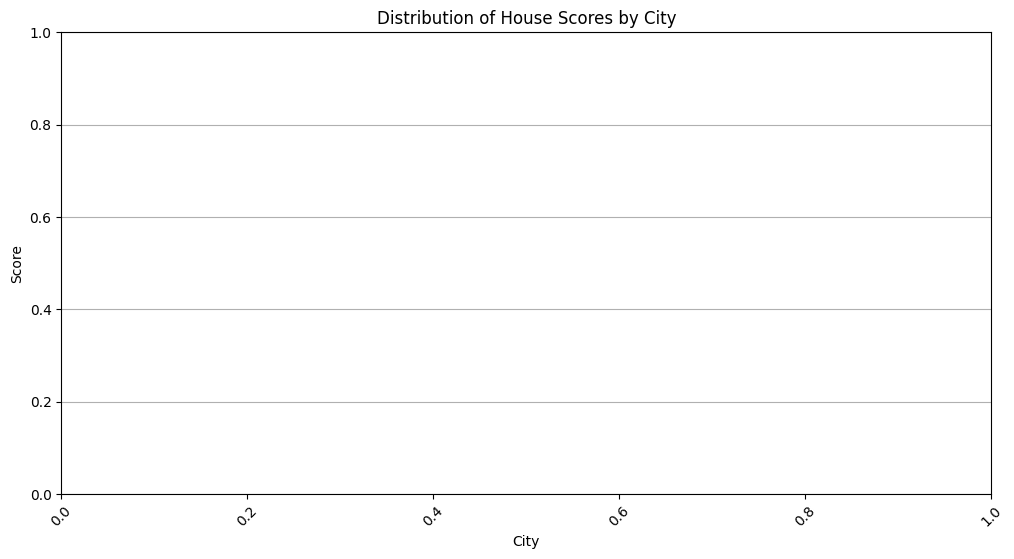

In [48]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='addressLocality', y='Score', data=data_scored)

plt.title('Distribution of House Scores by City')
plt.xlabel('City')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

In [49]:
df = pd.DataFrame(data_scored)

# Prepare X (features) and y (target)
X = df[[
        # 'price',
        'property-beds', 
        'property-baths', 
        'property-sqft', 
        'Property Type', 
        # 'avg_convenience_dist', 
        # 'avg_transit_distance', 
        # 'avg_school_distance', 
        # 'Price-to-income Ratio',
        ]]
X = sm.add_constant(X)  # Adds intercept term
y = df["price"]

# Fit the OLS model
model = sm.OLS(y, X).fit()
# Extract coefficients (excluding the intercept)
coefficients = model.params.drop("const")
errors = model.bse.drop("const")

# Plotting
plt.figure(figsize=(8, 5))
coefficients.plot(kind='bar', yerr=errors, capsize=5, color='skyblue')
plt.title("Feature Impact on House Price (OLS Coefficients)")
plt.ylabel("Coefficient Value ($ Impact)")
plt.xticks(rotation=0)
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

ValueError: zero-size array to reduction operation maximum which has no identity